LSTM Model

In [84]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

Positive reviews are 249236 and negative reviews are 250000 of total 499236 


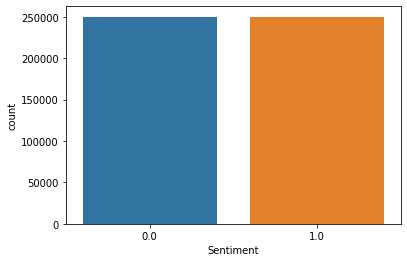

In [85]:
dataset = pd.read_csv('/content/Hotel_data.csv')
negative = len(dataset[dataset['Sentiment']== 0])
positive = len(dataset) - negative
sns.countplot(dataset['Sentiment'])
print('Positive reviews are {} and negative reviews are {} of total {} '.format(positive,negative,len(dataset)))

DATA PRE-PROCESSING

In [86]:
le = LabelEncoder()
training_reviews,testing_reviews,training_labels,testing_labels  = train_test_split(dataset['Review_concat'].values,dataset['Sentiment'].values,test_size = 0.2)
training_labels = le.fit_transform(training_labels)
testing_labels = le.fit_transform(testing_labels)

In [87]:
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_reviews)
testing_sequence = tokenizer.texts_to_sequences(testing_reviews)
train_pad_sequence = pad_sequences(training_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(testing_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
print('Total Unique Words : {}'.format(len(word_index)))

Total Unique Words : 46537


In [88]:
embedded_words = {}
with open('/content/glove.6B.100d.txt') as file:
    for line in file:
        words, coeff = line.split(maxsplit=1)
        coeff = np.array(coeff.split(),dtype = float)
        embedded_words[words] = coeff

In [89]:
embedding_matrix = np.zeros((len(word_index) + 1,100))
for word, i in word_index.items():
    embedding_vector = embedded_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

LSTM MODEL

In [90]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1,100,weights=[embedding_matrix],input_length=200,
                            trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])


In [91]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          4653800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [112]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy() , optimizer='Adam' , metrics = 'accuracy')
history = model.fit(train_pad_sequence,training_labels,epochs = 8 ,validation_data=(test_pad_sequence,testing_labels))

Epoch 1/8
12481/12481 [==============================] - 247s 20ms/step - loss: 0.1339 - accuracy: 0.9543 - val_loss: 0.1283 - val_accuracy: 0.9562
Epoch 2/8
12481/12481 [==============================] - 248s 20ms/step - loss: 0.1292 - accuracy: 0.9568 - val_loss: 0.1294 - val_accuracy: 0.9552
Epoch 3/8
12481/12481 [==============================] - 249s 20ms/step - loss: 0.1260 - accuracy: 0.9581 - val_loss: 0.1248 - val_accuracy: 0.9577
Epoch 4/8
12481/12481 [==============================] - 249s 20ms/step - loss: 0.1210 - accuracy: 0.9600 - val_loss: 0.1196 - val_accuracy: 0.9591
Epoch 5/8
12481/12481 [==============================] - 249s 20ms/step - loss: 0.1179 - accuracy: 0.9612 - val_loss: 0.1200 - val_accuracy: 0.9591
Epoch 6/8
12481/12481 [==============================] - 249s 20ms/step - loss: 0.1160 - accuracy: 0.9618 - val_loss: 0.1221 - val_accuracy: 0.9600
Epoch 7/8
12481/12481 [==============================] - 249s 20ms/step - loss: 0.1136 - accuracy: 0.9626 - val_

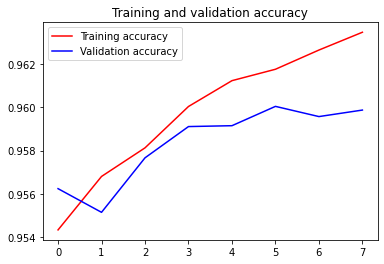

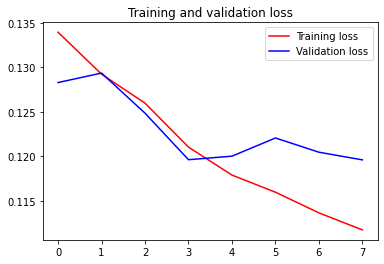

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [115]:
print('Training Accuracy: {}'.format(max(acc)))
print('Validation Accuracy: {}'.format(max(val_acc)))

Training Accuracy: 0.9634590744972229
Validation Accuracy: 0.9600392580032349


In [96]:
yhat = model.predict(train_pad_sequence, verbose=0)
print(yhat)

[[0.02044871]
 [0.00230072]
 [0.02670208]
 ...
 [0.9998116 ]
 [0.94671965]
 [0.01945555]]


In [111]:
# make predictions
trainPredict = model.predict(train_pad_sequence)
testPredict = model.predict(test_pad_sequence)
